In [1]:
from __future__ import print_function, division
import sys
sys.path.insert(0, 'lib')
import numpy as np
import random
import pydicom
import os
import matplotlib.pyplot as plt
import pickle
import math
import pydicom
from utils import make_giant_mat, make_dictionary, make_echo_dict
from shutil import copyfile
import nibabel as nib

from inference_utils import run_inference
from make_inference_csv import *
from compare_segmentations import get_dice_scores, get_jaccard_indices, compare_region_means,compare_region_changes

Using TensorFlow backend.


# Specify which subjects you want to analyze using their OAI Patient ID

In [2]:
with open('/data/dominik_data/train_val_test/pid_train.pickle', 'rb') as f:    
    pid_train = pickle.load(f)
    
with open('/data/dominik_data/train_val_test/pid_val.pickle', 'rb') as f:    
    pid_val = pickle.load(f)
      
with open('/data/dominik_data/train_val_test/pid_test.pickle', 'rb') as f:    
    pid_test = pickle.load(f)
    
with open('/data/dominik_data/train_val_test/pid_test_expert2.pickle', 'rb') as f:
    pid_expert2 = pickle.load(f)
    
with open('/data/dominik_data/train_val_test/pid_test_expert2_years.pickle', 'rb') as f:
    pid_expert2_yrs = pickle.load(f)

print(pid_test)
print()
print(pid_expert2)
print(pid_expert2_yrs)

['9543086' '9123289' '9260036' '9435250' '9909311' '9518827' '9013634'
 '9245760' '9458093' '9405107' '9120358' '9279874' '9376146' '9529761']

['9435250' '9013634' '9909311' '9279874' '9260036']
[4 8 8 4 8]


# Make Pandas Data Frame and CSV file to specify which image files you want to have analyzed


In [3]:
predict_pd = make_expert_csv_all_years(pID=pid_test,img_dir='/data/kevin_data/images', dir_to_save='/data/kevin_data/predicted')

expert1_pd = make_expert_csv_all_years(pID=pid_test, img_dir='/data/kevin_data/images',dir_to_save='/data/kevin_data/qmetric')

# We only have segmentations for one timepoint for the subjects segmented by expert2 and these are nifti files
expert2_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/expert2', 
                                            seg_provided=True, 
                                            seg_format = "numpy")

predict_subset_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/predicted', 
                                            seg_provided=True, 
                                            seg_format = "numpy",
                                            csv_filename = 'file_paths_subset.csv')

expert1_subset_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/qmetric', 
                                            seg_provided=True, 
                                            seg_format = "numpy",
                                            csv_filename = 'file_paths_subset.csv')
predict_subset_pd.head()



/data/kevin_data/expert2
/data/kevin_data/predicted
/data/kevin_data/qmetric


,img_dir,seg_path,refined_seg_path,t2_img_path,t2_region_json_path
0,/data/kevin_data/images/YR4/9435250/T2,/data/kevin_data/predicted/segmentations/94352...,/data/kevin_data/predicted/segmentations_refin...,/data/kevin_data/predicted/t2maps/9435250_4,/data/kevin_data/predicted/region_means/943525...
0,/data/kevin_data/images/YR8/9013634/T2,/data/kevin_data/predicted/segmentations/90136...,/data/kevin_data/predicted/segmentations_refin...,/data/kevin_data/predicted/t2maps/9013634_8,/data/kevin_data/predicted/region_means/901363...
0,/data/kevin_data/images/YR8/9909311/T2,/data/kevin_data/predicted/segmentations/99093...,/data/kevin_data/predicted/segmentations_refin...,/data/kevin_data/predicted/t2maps/9909311_8,/data/kevin_data/predicted/region_means/990931...
0,/data/kevin_data/images/YR4/9279874/T2,/data/kevin_data/predicted/segmentations/92798...,/data/kevin_data/predicted/segmentations_refin...,/data/kevin_data/predicted/t2maps/9279874_4,/data/kevin_data/predicted/region_means/927987...
0,/data/kevin_data/images/YR8/9260036/T2,/data/kevin_data/predicted/segmentations/92600...,/data/kevin_data/predicted/segmentations_refin...,/data/kevin_data/predicted/t2maps/9260036_8,/data/kevin_data/predicted/region_means/926003...


# Generate T2 maps for your MESE images
### This is the fun part!
- If you provide a value for the 'expert_pd' argument, it will use your provided segmentations

- If you provide a value for the 'to_segment_pd' argument, it will automatically segment the cartilage and then use that auto-segmentation to generate the T2 maps. By default, this uses our trained model, but model weights can bbe changed via the 'model_weights_file' argument and the model can be changed by altering the inference.get_model function in inference.py. 

- In addition to generating 3D T2 maps, it also provides the segmentations used to generate those T2 maps as 3D numpy arrays and json files that summarize the avg T2 value in each anatomical region of the cartilage plate

- These results are all saved in the destinations specied in your Pandas dataframe (expert_pd or to_segment_pd) that you made in the previous step

In [4]:
run_inference(to_segment_pd = predict_pd)
              
run_inference(expert_pd = expert1_pd)
              
run_inference(expert_pd = expert2_pd)

# We don't need to generate additional segmentations for the 'predict_subset_pd' or 'expert1_subset_pd' 
# because they are already generated as part of the 'predict_pd' and 'expert1_pd'

--------------------------------
Automatically segmenting images and using those segmentations to analyze MESE MRIs
--------------------------------

/data/kevin_data/images/YR4/9543086/T2


/home/Kevin/AutomaticKneeMRISegmentation/models.py:97: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), padding="same", strides=(2, 2))`
  output_shape=deconv_shape)(conv),
/home/Kevin/AutomaticKneeMRISegmentation/models.py:97: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(256, (3, 3), padding="same", strides=(2, 2))`
  output_shape=deconv_shape)(conv),
/home/Kevin/AutomaticKneeMRISegmentation/models.py:97: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(128, (3, 3), padding="same", strides=(2, 2))`
  output_shape=deconv_shape)(conv),
/home/Kevin/AutomaticKneeMRISegmentation/models.py:97: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(64, (3, 3), padding="same", strides=(2, 2))`
  output_shape=deconv_shape)(conv),
/home/Kevin/AutomaticKneeMRISegmentation/models.py:97: UserWarning: Update your `Conv2DTranspose` call to the Ker

/data/kevin_data/images/YR8/9543086/T2
/data/kevin_data/images/YR4/9123289/T2
/data/kevin_data/images/YR8/9123289/T2
/data/kevin_data/images/YR4/9260036/T2
/data/kevin_data/images/YR8/9260036/T2
/data/kevin_data/images/YR4/9435250/T2
/data/kevin_data/images/YR8/9435250/T2
/data/kevin_data/images/YR4/9909311/T2
/data/kevin_data/images/YR8/9909311/T2
/data/kevin_data/images/YR4/9518827/T2
/data/kevin_data/images/YR8/9518827/T2
/data/kevin_data/images/YR4/9013634/T2
/data/kevin_data/images/YR8/9013634/T2
/data/kevin_data/images/YR4/9245760/T2
/data/kevin_data/images/YR8/9245760/T2
/data/kevin_data/images/YR4/9458093/T2
/data/kevin_data/images/YR8/9458093/T2
/data/kevin_data/images/YR4/9405107/T2
/data/kevin_data/images/YR8/9405107/T2
/data/kevin_data/images/YR4/9120358/T2
/data/kevin_data/images/YR8/9120358/T2
/data/kevin_data/images/YR4/9279874/T2
/data/kevin_data/images/YR8/9279874/T2
/data/kevin_data/images/YR4/9376146/T2
/data/kevin_data/images/YR8/9376146/T2
/data/kevin_data/images/Y

In [6]:
# Flip the expert segmentations if you haven't already
# for file in os.listdir('/data/kevin_data/expert2/segmentations'):
#     if file[-4:]=='.npy':
#         temp = np.load(os.path.join('/data/kevin_data/expert2/segmentations',file))
#         temp = np.flip(temp, axis = 0)
#         np.save(os.path.join('/data/kevin_data/expert2/segmentations',file),temp)

# Compare two segmentation approaches for a single set of images
- Quantify how closely the two segmentations agree with one another using Dice Score and Jaccard Index
- Quantify how closely the downstream T2 measurements correlate for each region using Pearson correlation
- Quantify the mean absolute difference in T2 measurements for each region


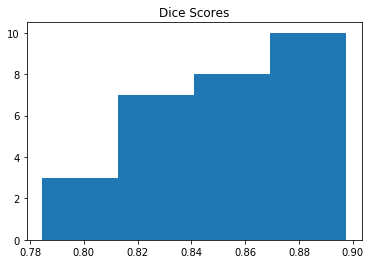

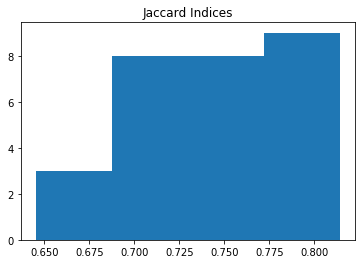

In [22]:
source1 = expert1_pd.copy()
source2 = predict_pd.copy()

source1_seg = [i + '.npy' for i in np.array(source1.refined_seg_path)]
# source1_seg = list(source1.seg_path)

source2_seg = [i + '.npy' for i in np.array(source2.refined_seg_path)]
# source2_seg = list(source2.seg_path)


# Get Dice Score 
dice_scores = get_dice_scores(source1_seg, source2_seg)

# Get Jaccard Index
jaccard_indices = get_jaccard_indices(source1_seg, source2_seg)

# See how well they agree in terms of the average T2 value in each cartilage region of each image
source1_regions = list(source1.t2_region_json_path)
source2_regions = list(source2.t2_region_json_path)
correlation_dict, mean_abs_diff_dict = compare_region_means(source1_regions, source2_regions, results_path=None)


# See how well they agree in terms of the average T2 change over time in each cartilage region of each image
source1_regions1 = [i for i in source1_regions if i[-6]=='4']
source1_regions2 = [i for i in source1_regions if i[-6]=='8']
source2_regions1 = [i for i in source2_regions if i[-6]=='4']
source2_regions2 = [i for i in source2_regions if i[-6]=='8']

if len(source1_regions1)==len(source1_regions2):
    change_correlation_dict, change_mean_abs_diff_dict = compare_region_changes(source1_regions1,
                                                                                source1_regions2, 
                                                                                source2_regions1,
                                                                                source2_regions2, 
                                                                                results_path=None)
plt.hist(dice_scores, bins = 4)
plt.title("Dice Scores")
plt.show()

plt.hist(jaccard_indices, bins = 4)
plt.title("Jaccard Indices")
plt.show()

In [25]:
mean_abs_diff_dict

{'all': 0.40568825137207604,
 'superficial': 0.5102981384967771,
 'deep': 0.5133353160956593,
 'SLA': 1.435832283184708,
 'SLC': 1.2316775209888513,
 'SLP': 0.8778900633798907,
 'SUA': 1.981700806958975,
 'SUC': 0.9058125601407949,
 'SUP': 1.1572836315188764,
 'DLA': 0.9914941838863768,
 'DLC': 1.3569768929004649,
 'DLP': 1.1993144862661858,
 'DUA': 1.6699665143668374,
 'DUC': 1.9641337048921395,
 'DUP': 1.3050470322961487,
 'LA': 1.027298868244049,
 'LC': 0.7407185102125499,
 'LP': 0.7816603039841389,
 'UA': 1.521837531864047,
 'UC': 1.0878131592927356,
 'UP': 0.9538690813465492}

In [ ]:
from loss_functions import dice_loss_test_volume

In [ ]:
dice_loss_test_volume(np.flip(elka, axis = 0), qmetric)

In [ ]:
for file in os.listdir('/data/kevin_data/expert2/segmentations'):
    if file[-4:]=='.npy':
        temp = np.load(os.path.join('/data/kevin_data/expert2/segmentations',file))
        temp = np.flip(temp, axis = 0)
        np.save(os.path.join('/data/kevin_data/expert2/segmentations',file),temp)